### Aleksandra Jonas, Aleksandra Gronowka, Iwona Christop

## Przygotowanie danych

In [4]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import json
from tensorflow import keras
%matplotlib inline

In [5]:
import sys
import subprocess
import pkg_resources
import numpy as np
peachy = []

required = { 'scikit-image'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing: 
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

def load_train_data(input_dir, newSize=(227,227)):
    import numpy as np
    import pandas as pd
    import os
    from skimage.io import imread
    import cv2 as cv
    from pathlib import Path
    import random
    from shutil import copyfile, rmtree
    import json

    import seaborn as sns
    import matplotlib.pyplot as plt

    import matplotlib
    
    image_dir = Path(input_dir)
    categories_name = []
    for file in os.listdir(image_dir):
        d = os.path.join(image_dir, file)
        if os.path.isdir(d):
            categories_name.append(file)

    folders = [directory for directory in image_dir.iterdir() if directory.is_dir()]

    train_img = []
    categories_count=[]
    labels=[]
    for i, direc in enumerate(folders):
        count = 0
        
        for obj in direc.iterdir():
            if os.path.isfile(obj) and os.path.basename(os.path.normpath(obj)) != 'desktop.ini':
                labels.append(os.path.basename(os.path.normpath(direc)))
                count += 1
                img = imread(obj)#zwraca ndarry postaci xSize x ySize x colorDepth
                if img.shape[-1] == 256:
                    img = np.repeat(img[..., np.newaxis], 3, axis=2)
                elif img.shape[-1] == 4:
                    img = img[:, :, :3]
                img = cv.resize(img, newSize, interpolation=cv.INTER_AREA)# zwraca ndarray
                img = img / 255#normalizacja
                train_img.append(img)
        categories_count.append(count)
    X={}
    X["values"] = np.array(train_img)
    X["categories_name"] = categories_name
    X["categories_count"] = categories_count
    X["labels"]=labels
    return X

def load_test_data(input_dir, newSize=(227,227)):
    import numpy as np
    import pandas as pd
    import os
    from skimage.io import imread
    import cv2 as cv
    from pathlib import Path
    import random
    from shutil import copyfile, rmtree
    import json

    import seaborn as sns
    import matplotlib.pyplot as plt

    import matplotlib

    image_path = Path(input_dir)

    labels_path = image_path.parents[0] / 'test_labels.json'

    jsonString = labels_path.read_text()
    objects = json.loads(jsonString)

    categories_name = []
    categories_count=[]
    count = 0
    c = objects[0]['value']
    for e in  objects:
        if e['value'] != c:
            categories_count.append(count)
            c = e['value']
            count = 1
        else:
            count += 1
        if not e['value'] in categories_name:
            categories_name.append(e['value'])

    categories_count.append(count)
    
    test_img = []

    labels=[]
    for e in objects:
        p = image_path / e['filename']
        img = imread(p)#zwraca ndarry postaci xSize x ySize x colorDepth
        if img.shape[-1] == 4:
            img = img[:, :, :3]
        img = cv.resize(img, newSize, interpolation=cv.INTER_AREA)# zwraca ndarray
        img = img / 255#normalizacja
        test_img.append(img)
        labels.append(e['value'])

    X={}
    X["values"] = np.array(test_img)
    X["categories_name"] = categories_name
    X["categories_count"] = categories_count
    X["labels"]=labels
    return X



In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

data_train = load_train_data(f"./train_test_sw/train_sw_unity")
values_train = data_train['values']
labels_train = data_train['labels']
data_test = load_test_data("./train_test_sw/test_sw")
X_test = data_test['values']
y_test = data_test['labels']

X_train, X_validate, y_train, y_validate = train_test_split(values_train, labels_train, test_size=0.2, random_state=42)

class_le = LabelEncoder()
y_train_enc = class_le.fit_transform(y_train)
y_validate_enc = class_le.fit_transform(y_validate)
y_test_enc = class_le.fit_transform(y_test)

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train_enc))
validation_ds = tf.data.Dataset.from_tensor_slices((X_validate, y_validate_enc))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test_enc))

train_ds_size = tf.data.experimental.cardinality(train_ds).numpy()
test_ds_size = tf.data.experimental.cardinality(test_ds).numpy()
validation_ds_size = tf.data.experimental.cardinality(validation_ds).numpy()

train_ds = (train_ds
                .shuffle(buffer_size=train_ds_size)
                .batch(batch_size=32, drop_remainder=True))
test_ds = (test_ds
                .shuffle(buffer_size=train_ds_size)
                .batch(batch_size=32, drop_remainder=True))
validation_ds = (validation_ds
                .shuffle(buffer_size=train_ds_size)
                .batch(batch_size=32, drop_remainder=True))

## AlexNet

In [7]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import tensorflow as tf

alexnet = keras.models.Sequential([
keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3)),
keras.layers.BatchNormalization(),
keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
keras.layers.BatchNormalization(),
keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
keras.layers.BatchNormalization(),
keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
keras.layers.BatchNormalization(),
keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
keras.layers.BatchNormalization(),
keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
keras.layers.Flatten(),
keras.layers.Dense(4096, activation='relu'),
keras.layers.Dropout(.5),
keras.layers.Dense(4096, activation='relu'),
keras.layers.Dropout(.5),
keras.layers.Dense(10, activation='softmax')
])

In [8]:
alexnet.compile(loss='sparse_categorical_crossentropy', optimizer=tf.optimizers.SGD(lr=.001), metrics=['accuracy'])
alexnet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 55, 55, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 27, 27, 256)      1024      
 hNormalization)                                                 
                                                        

In [9]:
checkpoint = ModelCheckpoint("alex_2.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')

alex = alexnet.fit_generator(
    steps_per_epoch=len(train_ds), 
    generator=train_ds, 
    validation_data= validation_ds, 
    validation_steps=len(validation_ds), 
    epochs=25, 
    callbacks=[checkpoint,early])

/var/folders/6b/j4d60ym516x2s6wymzj707rh0000gn/T/ipykernel_37874/1998863165.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  alex = alexnet.fit_generator(


Epoch 1/25


2023-01-11 20:31:44.007163: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


50/50 [==============================] - ETA: 0s - loss: 3.8100 - accuracy: 0.3950
Epoch 1: val_accuracy improved from -inf to 0.29688, saving model to alex_2.h5
50/50 [==============================] - 46s 896ms/step - loss: 3.8100 - accuracy: 0.3950 - val_loss: 1.8302 - val_accuracy: 0.2969
Epoch 2/25
50/50 [==============================] - ETA: 0s - loss: 1.3961 - accuracy: 0.5281
Epoch 2: val_accuracy improved from 0.29688 to 0.38281, saving model to alex_2.h5
50/50 [==============================] - 46s 918ms/step - loss: 1.3961 - accuracy: 0.5281 - val_loss: 1.9363 - val_accuracy: 0.3828
Epoch 3/25
50/50 [==============================] - ETA: 0s - loss: 1.0805 - accuracy: 0.5956
Epoch 3: val_accuracy did not improve from 0.38281
50/50 [==============================] - 48s 955ms/step - loss: 1.0805 - accuracy: 0.5956 - val_loss: 2.2350 - val_accuracy: 0.3438
Epoch 4/25
50/50 [==============================] - ETA: 0s - loss: 0.8866 - accuracy: 0.6600
Epoch 4: val_accuracy did n

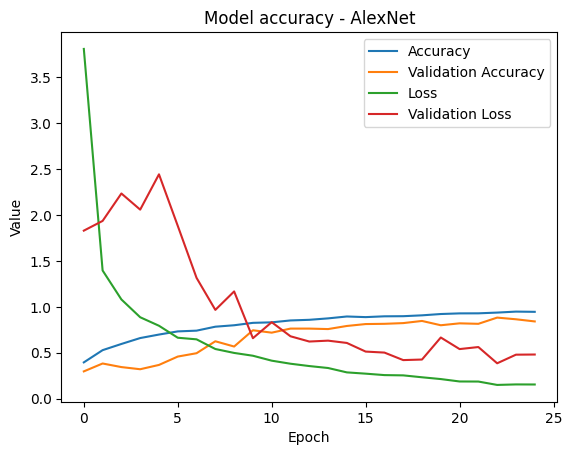

In [10]:
plt.plot(alex.history["accuracy"])
plt.plot(alex.history['val_accuracy'])
plt.plot(alex.history['loss'])
plt.plot(alex.history['val_loss'])
plt.title(f"Model accuracy - AlexNet")
plt.ylabel("Value")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","Loss","Validation Loss"])
plt.show()

In [11]:
alexnet.evaluate(test_ds)

8/8 [==============================] - 4s 450ms/step - loss: 0.4419 - accuracy: 0.8516


[0.4419291615486145, 0.8515625]

## MLP

In [14]:
X_train = X_train.flatten().reshape(X_train.shape[0], int(np.prod(X_train.shape) / X_train.shape[0]))
X_test = X_test.flatten().reshape(X_test.shape[0], int(np.prod(X_test.shape) / X_test.shape[0]))

In [21]:
from sklearn.neural_network import MLPClassifier
from tqdm import tqdm

def test_mlp(X_train, y_train, X_val, y_val, X_test, y_test, hidden_layer_sizes, alpha, max_iter):
    mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, alpha=alpha, max_iter=max_iter)
    accuracy = []

    result = {
        'num_layers': len(hidden_layer_sizes),
        'layer_sizes': hidden_layer_sizes,
        'regularization': alpha,
        'max_iter': max_iter
    }

    for i in tqdm(range(max_iter)):
        mlp.partial_fit(X_train, y_train, np.unique(y_train))
        accuracy.append(mlp.score(X_train, y_train))
        if i == 50:
            result['checkpoint_train_accuracy'] = np.mean(accuracy)
            result['checkpoint_val_accuracy'] = mlp.score(X_val, y_val)
            result['checkpoint_test_accuracy'] = mlp.score(X_test, y_test)

    result['full_train_accuracy'] = np.mean(accuracy)
    result['full_val_accuracy'] = mlp.score(X_val, y_val)
    result['full_test_accuracy'] = mlp.score(X_test, y_test)
    result['accuracy_curve'] = accuracy
    result['loss_curve'] = mlp.loss_curve_

    return result

def print_result(result):
    print(f"NUMBER OF HIDDEN LAYERS = {result['num_layers']}")
    print(f"HIDDEN LAYER SIZES = {result['layer_sizes']}")
    print(f"REGULARIZATION = {result['regularization']}")
    print("\n50 EPOCHS")
    print(f"train_accuracy = {round(result['checkpoint_train_accuracy'] * 100, 2)}%")
    print(f"val_accuracy = {round(result['checkpoint_val_accuracy'] * 100, 2)}%")
    print(f"test_accuracy = {round(result['checkpoint_test_accuracy'] * 100, 2)}%")
    print(f"\n{result['max_iter']} EPOCHS")
    print(f"train_accuracy = {round(result['full_train_accuracy'] * 100, 2)}%")
    print(f"val_accuracy = {round(result['checkpoint_val_accuracy'] * 100, 2)}%")
    print(f"test_accuracy = {round(result['full_test_accuracy'] * 100, 2)}%")

def get_plot(result):
    f = plt.figure(figsize=(12,6))
    plt.plot(result['loss_curve'], label='loss')
    plt.plot(result['accuracy_curve'], label='accuracy')
    plt.legend(loc='best')
    plt.xlabel('number of iterations')
    plt.grid()
    plt.show()



In [22]:
from sklearn.model_selection import train_test_split

NEW_SIZE = 64

ONE_LAYER = (286,)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.05, random_state=42)

all_results = []

In [23]:
all_results.append(test_mlp(X_train, y_train, X_val, y_val, X_test, y_test, hidden_layer_sizes=ONE_LAYER, alpha=0.1, max_iter=200))
all_results.append(test_mlp(X_train, y_train, X_val, y_val, X_test, y_test, hidden_layer_sizes=ONE_LAYER, alpha=0.001, max_iter=200))

100%|██████████| 200/200 [39:45<00:00, 11.93s/it]


NUMBER OF HIDDEN LAYERS = 1
HIDDEN LAYER SIZES = (286,)
REGULARIZATION = 0.1

50 EPOCHS
train_accuracy = 68.78%
val_accuracy = 58.02%
test_accuracy = 53.67%

200 EPOCHS
train_accuracy = 90.29%
val_accuracy = 58.02%
test_accuracy = 59.07%


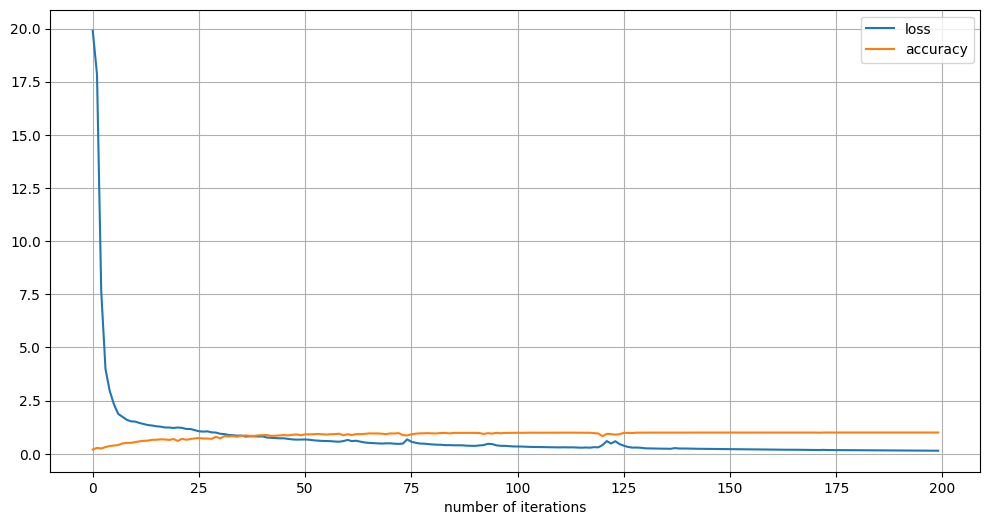

NUMBER OF HIDDEN LAYERS = 1
HIDDEN LAYER SIZES = (286,)
REGULARIZATION = 0.001

50 EPOCHS
train_accuracy = 74.1%
val_accuracy = 56.79%
test_accuracy = 50.19%

200 EPOCHS
train_accuracy = 92.63%
val_accuracy = 56.79%
test_accuracy = 54.44%


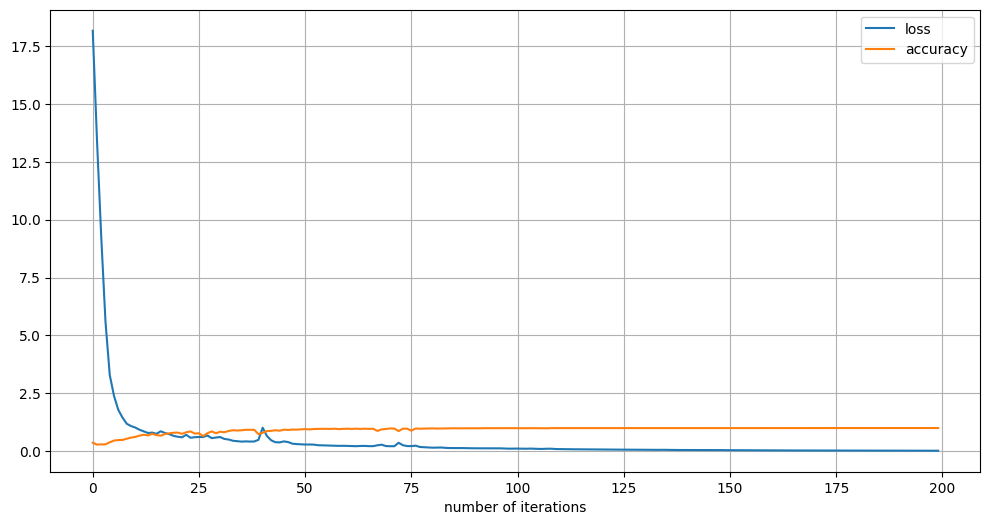

In [38]:
for result in all_results:
    print_result(result)
    get_plot(result)